### Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os, glob
import random
import pickle

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from albumentations import Compose, Normalize, Resize

import matplotlib.pyplot as plt
%matplotlib inline

### Check Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load Encoder/Decoder

In [3]:
with open('encoder_decoder.pkl', 'rb') as f:
    encode_decode_labels = pickle.load(f)
classes = encode_decode_labels['classes']
to_class = encode_decode_labels['to_class']

### Load Data

In [4]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

### Make Dataset

In [5]:
image_size = 32
batch_size = 32

NOTE: I've chosen `albumentations` transforms because this library uses opencv under the hood and it is more convenient than original torchvision.transforms which uses PIL

In [6]:
transform = Compose([Resize(image_size, image_size),
                     Normalize(
                         mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]
                     )])

In [7]:
class WeseeDataset(data.Dataset):

    def __init__(self,
                 df,
                 classes,
                 transform=None,
                 size=32):
        """
        df: dataframe with all data
        classes: dict with map to encode labels
        transform: whether to transform data
        size: size of train/test image
        """
        self.df = df
        self.classes = classes
        self.transform = transform
        self.size = size
               
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):
        
        file = self.df.iloc[index]
        # get image
        image = self.__load_image(file.filename)
        
        # get label
        word = file.label
        label = self.classes[word]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            image = image / 255.
        image = torch.from_numpy(image).float().permute([2, 0, 1])
        return image, label

    
    def __load_image(self, path):
        img = cv2.imread(path)
        # if original image larger we downscale else we upscale
        if min(img.shape) > self.size:
            img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
        else:
            img = cv2.resize(img, (self.size, self.size))
        return img

In [8]:
# training dataset:
dataset_train = WeseeDataset(train, classes, transform=transform, size=image_size)
# validation dataset:
dataset_valid = WeseeDataset(valid, classes, transform=transform, size=image_size)

train_loader = data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4)

# do not shuffle for validation
valid_loader = data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4)

### Dataset Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32])
['dark', 'ok', 'dark', 'ok']


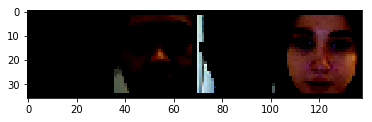

In [9]:
images, labels =  next(iter(train_loader))
print(images[:4].shape)
print([to_class[l] for l in labels[:4].numpy()])

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(torchvision.utils.make_grid(images[:4]))

## Build Model

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 3)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model = LeNet()
model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [11]:
model = model.to(device)

In [12]:
# parameters
learning_rate = 1e-3
epochs = 30
prev_acc = 0

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training Model

In [14]:
for epoch in range(epochs):
            
    train_loss = []
    val_loss = []
    
    # training:
    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        pred = model(images)
        loss = loss_fn(pred, labels)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()                       
        optimizer.step()

    # validation:
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            pred = model(images)
            loss = loss_fn(pred, labels)
            _, predicted = torch.max(pred, dim=1)
            val_loss.append(loss.item())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calculate acc
    val_acc = correct / total
    
    lr = None
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Epoch: {}, Train Loss: {:.3f}, Val Loss: {:.3f}, Val Acc: {:.3f}".format(
        epoch+1, np.mean(train_loss), np.mean(val_loss), val_acc))

    # save checkpoint
    if val_acc > prev_acc:
        prev_acc = val_acc
        path = './model/model.pth'
        state = {'epoch': epoch + 1,
                 'state_dict': model.state_dict(),
                 'optimizer': optimizer.state_dict()}
        torch.save(state, path)
        print("Model Saved. val acc: {:.3f}".format(val_acc))

Epoch: 1, Train Loss: 1.073, Val Loss: 1.025, Val Acc: 0.471
Model Saved. val acc: 0.471
Epoch: 2, Train Loss: 0.927, Val Loss: 0.848, Val Acc: 0.765
Model Saved. val acc: 0.765
Epoch: 3, Train Loss: 0.719, Val Loss: 0.626, Val Acc: 0.824
Model Saved. val acc: 0.824
Epoch: 4, Train Loss: 0.507, Val Loss: 0.530, Val Acc: 0.706
Epoch: 5, Train Loss: 0.372, Val Loss: 0.519, Val Acc: 0.765
Epoch: 6, Train Loss: 0.343, Val Loss: 0.497, Val Acc: 0.824
Epoch: 7, Train Loss: 0.306, Val Loss: 0.570, Val Acc: 0.824
Epoch: 8, Train Loss: 0.250, Val Loss: 0.461, Val Acc: 0.824
Epoch: 9, Train Loss: 0.321, Val Loss: 0.555, Val Acc: 0.824
Epoch: 10, Train Loss: 0.258, Val Loss: 0.665, Val Acc: 0.824
Epoch: 11, Train Loss: 0.235, Val Loss: 0.449, Val Acc: 0.824
Epoch: 12, Train Loss: 0.137, Val Loss: 0.437, Val Acc: 0.824
Epoch: 13, Train Loss: 0.173, Val Loss: 0.430, Val Acc: 0.824
Epoch: 14, Train Loss: 0.099, Val Loss: 0.568, Val Acc: 0.824
Epoch: 15, Train Loss: 0.100, Val Loss: 0.551, Val Acc: 0

## Check Model

In [15]:
# helper function to load model (checkpoint)
def load_checkpoint(model, optimizer, device, filename='checkpoint.pth'):
    # Note: input model and optimizer should be pre-defined. this routine only updates their states
    epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    model.to(device)
    # now individually transfer the optimizer parts
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    return model, optimizer, epoch

In [16]:
# load model
filename = './model/model.pth'

model, optimizer, prev_acc = load_checkpoint(model,
                                             optimizer,
                                             device,
                                             filename)

=> loading checkpoint './model/model.pth'
=> loaded checkpoint './model/model.pth' (epoch 23)


In [17]:
valid = pd.read_csv('valid.csv')
dataset_valid = WeseeDataset(valid, classes, transform=transform, size=image_size)

valid_loader = data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [18]:
model.eval()

correct = 0
total = 0
for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    pred = model(images)
    _, predicted = torch.max(pred, dim=1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
# calculate acc
val_acc = correct / total

print("Validation accuracy: {:.2f}%".format(val_acc*100))

Validation accuracy: 94.12%
